In [17]:
%load_ext autoreload
%autoreload 2



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [18]:
%reload_ext autoreload
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from setdir import *
from plotglider import *
from scipy.io import loadmat # to load bathymetry
import xarray as xr
import seaborn as sns
from scipy import stats

In [24]:
# Need to update this for reading from a netcdf file
yyyymmdd = '20220124'

# Load both glider datasets
file1 = 'unit_409_'+yyyymmdd+'_edit.nc'
infile = cat_interim_path(file1)
unit409 = xr.open_dataset(infile)

yyyymmdd = '20220126'


file1 = 'unit_398_'+yyyymmdd+'_edit.nc'
infile = cat_interim_path(file1)
unit398 = xr.open_dataset(infile)

# Load glider positions
yyyymmdd = '20220119'

file1 = 'unit_409_position_'+yyyymmdd+'.nc'
infile = cat_interim_path(file1)
unit409pos = xr.open_dataset(infile)

file1 = 'unit_398_position_'+yyyymmdd+'.nc'
infile = cat_interim_path(file1)
unit398pos = xr.open_dataset(infile)

# Location for bathymetry file
matlab_file = 'labsea_66.44W_45.68N_5min.mat'
input_bathy_file = cat_proc_path(matlab_file)
mat_data = loadmat(input_bathy_file)
bathy_data = mat_data['bathy']
bathylat = bathy_data['lat'][0][0].flatten()
bathylon = bathy_data['lon'][0][0].flatten()
bathy = bathy_data['depth'][0][0]



In [26]:
unit409

<xarray.Dataset>
Dimensions:                        (time: 55558)
Coordinates:
  * time                           (time) datetime64[ns] 2021-12-12 ... 2022-...
Data variables: (12/13)
    sci_water_temp                 (time) float64 ...
    sci_water_cond                 (time) float64 ...
    sci_oxy4_oxygen                (time) float64 ...
    derived_salinity               (time) float64 ...
    derived_potential_density      (time) float64 ...
    derived_potential_temperature  (time) float64 ...
    ...                             ...
    sci_bb2flsv9_b700_scaled       (time) float64 ...
    sci_bb2flsv9_chl_scaled        (time) float64 ...
    sci_flbbcd_cdom_units          (time) float64 ...
    sci_flbbcd_chlor_units         (time) float64 ...
    sci_flbbcd_bb_units            (time) float64 ...
    pressure_dbar                  (time) float64 ...

KeyError: 'm_gps_lon'

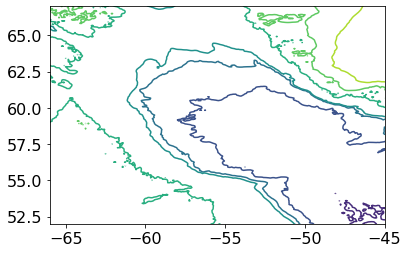

In [25]:
# Map the bathymetry and glider tracks 
# Ok, the glider tracks are spotty: Might mean that the m_gps_lon and m_gps_lat aren't the right variables to download!
map_tracks(bathylon,bathylat,bathy,unit409,unit398)

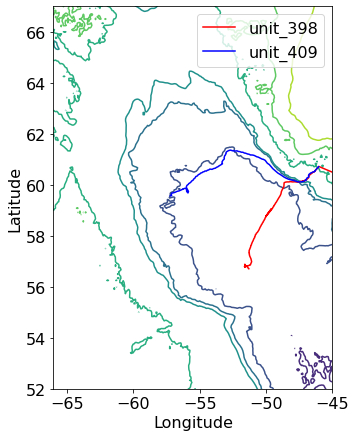

In [21]:
# Map the bathymetry and glider tracks 
# Ok, the glider tracks are spotty: Might mean that the m_gps_lon and m_gps_lat aren't the right variables to download!
map_tracks_pos(bathylon,bathylat,bathy,unit409pos,unit398pos)

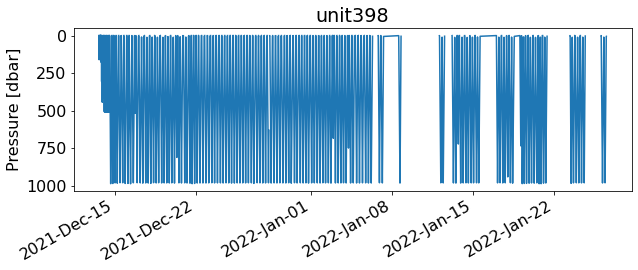

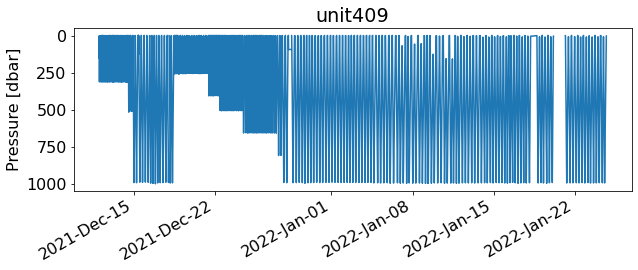

In [27]:
# Plot pressure against time
plot_pressure(unit398,'unit398')
plot_pressure(unit409,'unit409')
# Looks like we are missing recent data from unit398

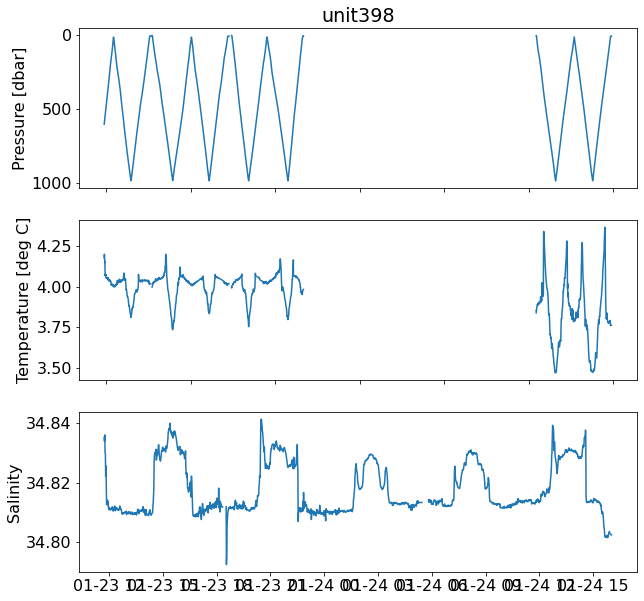

In [28]:
# Plot most recent 3 days
plot_tseries(unit398,3,'unit398')
#plot_tseries(unit409,3,'unit409')


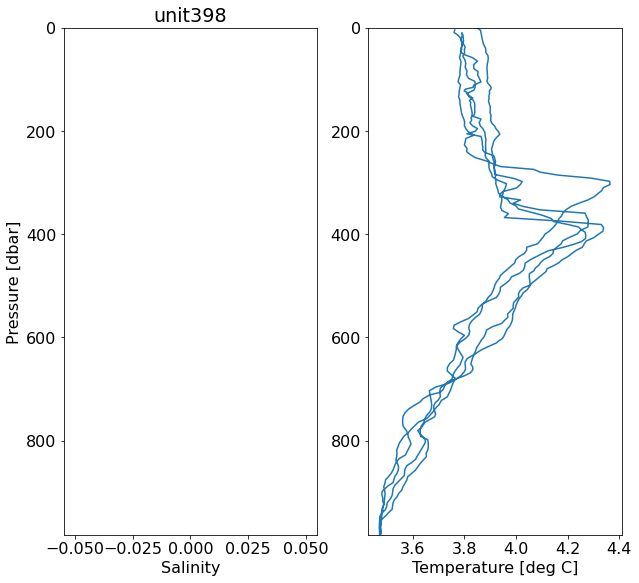

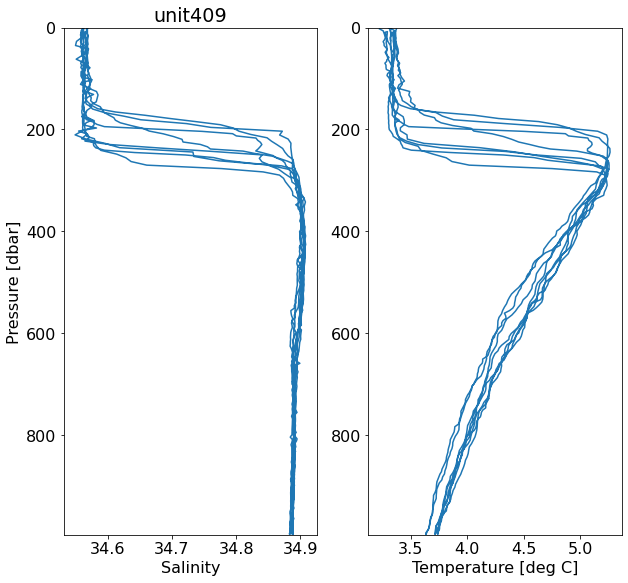

In [29]:
ndays=1
plot_profiles(unit398,ndays,'unit398')
plot_profiles(unit409,ndays,'unit409')


# Load profile indices (dive/climb)

In [30]:
idx_d={} ; idx_c={};
unit398, idx_d['398'], idx_c['398'] = dive_index(unit398) # Start on a dive
unit409, idx_d['409'], idx_c['409'] = dive_index(unit409) # Start on a climb

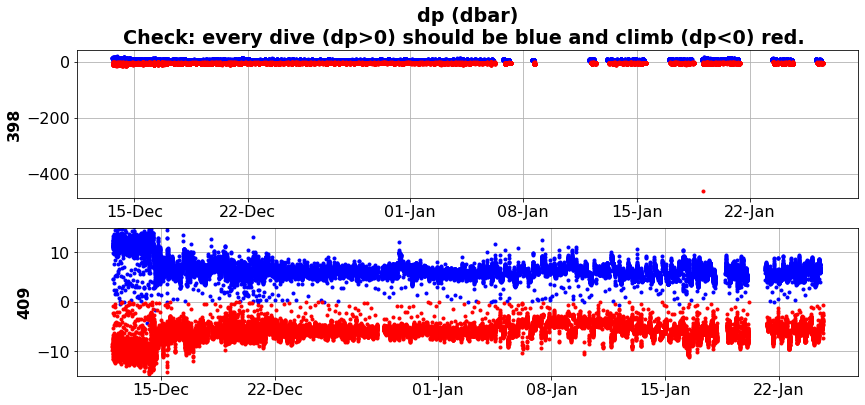

In [31]:
plot_dp(unit398,'398',unit409,'409',idx_d,idx_c)

# Trying to plot color plots of recent data

So idx_d and idx_u are dictionaries, where the keys are the serial number (numeric only) of the gliders, and the values are a numpy array of values [int64].

There is also now a field of the dataset called 'profile_index'.  Dive 1 is called 1.0, and the climb profile associated with the same cycle is called 1.5

Need to check out how it handles yos.  
- Seems fine, but also appears to discard a couple points near surface apogee that could be saved

unit398
* 1. Changing idive, idx was 111 is now  110
* 16. Changing iclimb, idx was 927, is now 928
* 21. Changing idive, idx was 1345 is now  1344
* 105. Changing idive, idx was 26665 is now  26664
* 123. Changing iclimb, idx was 32034, is now 32035

Shifting the dive to start one index sooner, or the climb to end one index later.

unit409

* 7. Changing iclimb, idx was 363, is now 364
* 54. Changing idive, idx was 3277 is now  3276
* 68. Changing iclimb, idx was 5842, is now 5843
* 77. Changing iclimb, idx was 8434, is now 8435
* 222. Changing iclimb, idx was 39853, is now 39854
* 229. Changing iclimb, idx was 42371, is now 42372
* 236. Changing iclimb, idx was 44907, is now 44908
* 240. Changing iclimb, idx was 46218, is now 46219

Shifting the dive to start one index sooner, or the climb to end one index later.



In [32]:
# Need to shift the endpoints of the index slightly, if the dive starts at 
# 5dbar or deeper but could start sooner.
unit_list = ['unit398', 'unit409']
idxname = 'profile_index'
presname = 'pressure_dbar'
for unit in unit_list:
    exec('ds1='+unit)
    pres = ds1[presname].values
    prof_idx = ds1[idxname].values
    dmin = int(prof_idx[np.where(~np.isnan(prof_idx))].min())
    dmax = int(prof_idx[np.where(~np.isnan(prof_idx))].max()-.5)

    print(unit)

    for i in range(dmin,dmax):
        idive = np.where(prof_idx==i)[0]
        iclimb = np.where(prof_idx==i+.5)[0]

        if len(idive):
            pstart = pres[idive[0]]
            if pstart>5:
                val1 = prof_idx[idive[0]-1]
                pstart_1 = pres[idive[0]-1]
                if np.isnan(val1) & (pstart_1<pstart):
                    print(str(i)+'. Changing idive, idx was '+str(idive[0])+' is now ',str(idive[0]-1))
                    prof_idx[idive[0]-1] = i
        if len(iclimb):
            pend = pres[iclimb[-1]]
            pend_1 = pres[iclimb[-1]+1]
            if pend_1 < pend:
                val2 = prof_idx[iclimb[-1]+1]
                if np.isnan(val2):
                    prof_idx[iclimb[-1]+1] = i+.5
                    print(str(i)+'. Changing iclimb, idx was '+str(iclimb[0])+', is now '+str(iclimb[0]+1))

unit398
1. Changing idive, idx was 3 is now  2
16. Changing iclimb, idx was 803, is now 804
21. Changing idive, idx was 1213 is now  1212
29. Changing iclimb, idx was 3718, is now 3719
30. Changing iclimb, idx was 4050, is now 4051
31. Changing iclimb, idx was 4284, is now 4285
44. Changing iclimb, idx was 7638, is now 7639
48. Changing iclimb, idx was 8885, is now 8886
49. Changing iclimb, idx was 9167, is now 9168
51. Changing iclimb, idx was 9729, is now 9730
98. Changing iclimb, idx was 24293, is now 24294
105. Changing idive, idx was 26367 is now  26366
110. Changing iclimb, idx was 27991, is now 27992
111. Changing iclimb, idx was 28293, is now 28294
123. Changing iclimb, idx was 31705, is now 31706
133. Changing iclimb, idx was 34763, is now 34764
137. Changing iclimb, idx was 36006, is now 36007
141. Changing iclimb, idx was 37247, is now 37248
144. Changing iclimb, idx was 38120, is now 38121
147. Changing iclimb, idx was 38809, is now 38810
unit409
7. Changing iclimb, idx was

# Now try some plotting

Using the profile information, plot color plots of data.

(array([ 327.,  376.,  656., 1466., 3085., 5411., 5768., 4089., 3339.,
        1696.,  379.,  122.,   58.,   54.,  194.,  300.,   95.,   74.,
          60.,  124.,  479., 1733., 3483., 6109., 6157., 3679., 1661.,
         871.,  383.,  208.]),
 array([-10.        ,  -9.33333333,  -8.66666667,  -8.        ,
         -7.33333333,  -6.66666667,  -6.        ,  -5.33333333,
         -4.66666667,  -4.        ,  -3.33333333,  -2.66666667,
         -2.        ,  -1.33333333,  -0.66666667,   0.        ,
          0.66666667,   1.33333333,   2.        ,   2.66666667,
          3.33333333,   4.        ,   4.66666667,   5.33333333,
          6.        ,   6.66666667,   7.33333333,   8.        ,
          8.66666667,   9.33333333,  10.        ]),
 <BarContainer object of 30 artists>)

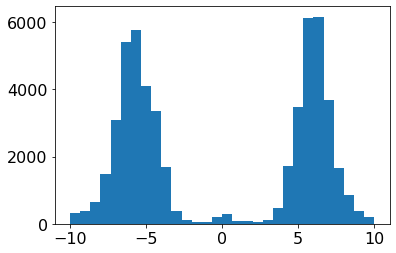

In [33]:
# Trying to decide what size bins to use 
dp = unit409.pressure_dbar.diff(dim='time')
plt.hist(dp, bins=30, range=(-10, 10))
#plt.set_xlabel('diff(pres)')
#plt.set_ylabel('Count')
# Use 10-m bins? with a median for value within the bin?

In [34]:
# Create a regularly gridded product with ~10m depth bins.
# Takes a little while (started 10:47, finished before 10:54)
grid409 = bin_dp(unit409, 'unit409', 10)
grid409.to_netcdf(cat_proc_path(grid409.attrs['unit']+'_bin10m.nc'), mode='w')

In [38]:
grid398 = bin_dp(unit398, 'unit398', 10)
grid398.to_netcdf(cat_proc_path(grid398.attrs['unit']+'_bin10m.nc'), mode='w')

In [39]:
grid398

<xarray.Dataset>
Dimensions:                        (pressure: 100, divenum: 330)
Coordinates:
  * divenum                        (divenum) float64 1.0 1.5 2.0 ... 165.0 165.5
  * pressure                       (pressure) float64 5.0 15.0 ... 985.0 995.0
Data variables:
    sci_water_temp                 (pressure, divenum) float64 0.1888 ... nan
    sci_water_cond                 (pressure, divenum) float64 2.721 ... nan
    sci_oxy4_oxygen                (pressure, divenum) float64 nan nan ... nan
    derived_salinity               (pressure, divenum) float64 32.38 ... nan
    derived_potential_density      (pressure, divenum) float64 1.026e+03 ... nan
    derived_potential_temperature  (pressure, divenum) float64 0.1886 ... nan
    sci_bb2flsv9_b532_scaled       (pressure, divenum) float64 nan nan ... nan
    sci_bb2flsv9_b700_scaled       (pressure, divenum) float64 nan nan ... nan
    sci_bb2flsv9_chl_scaled        (pressure, divenum) float64 nan nan ... nan
    time                           (pressure, divenum) datetime64[ns] 2021-12...
Attributes:
    unit:     unit398

# Simple color sections

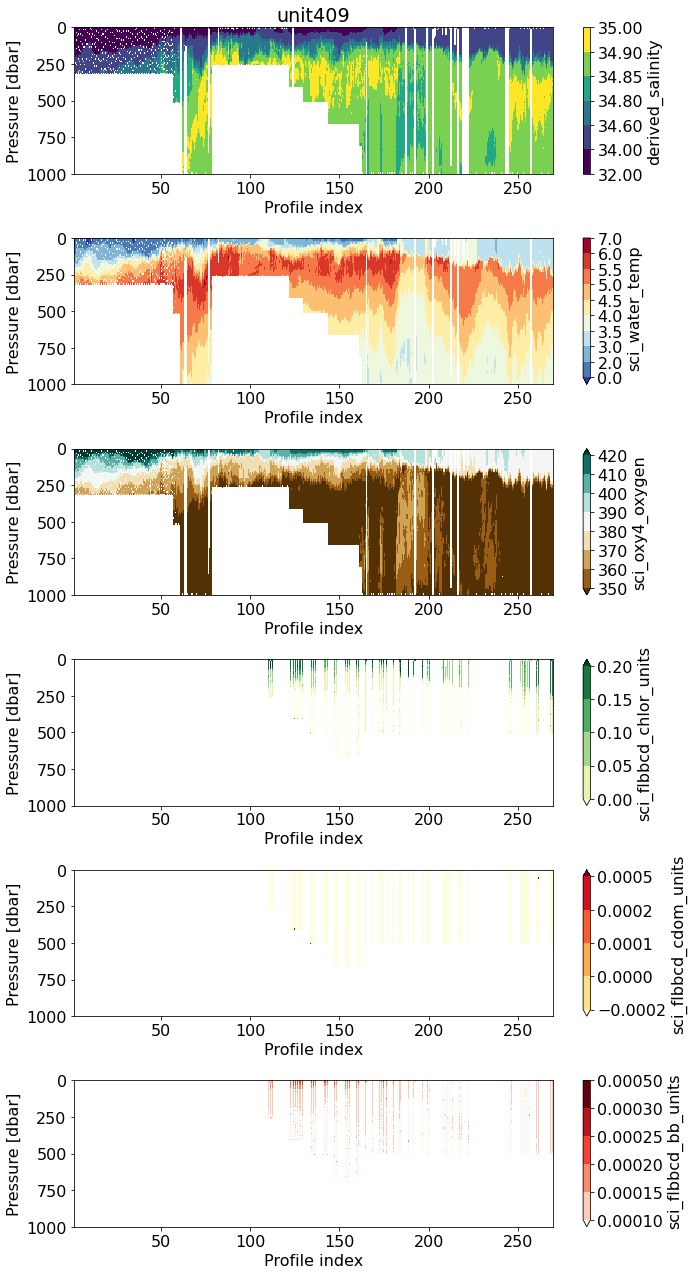

In [65]:
varlist = ['derived_salinity', 'sci_water_temp', 'sci_oxy4_oxygen',
           'sci_flbbcd_chlor_units', 'sci_flbbcd_cdom_units', 
           'sci_flbbcd_bb_units'
          ]
           
plot_sxn(grid409, varlist)


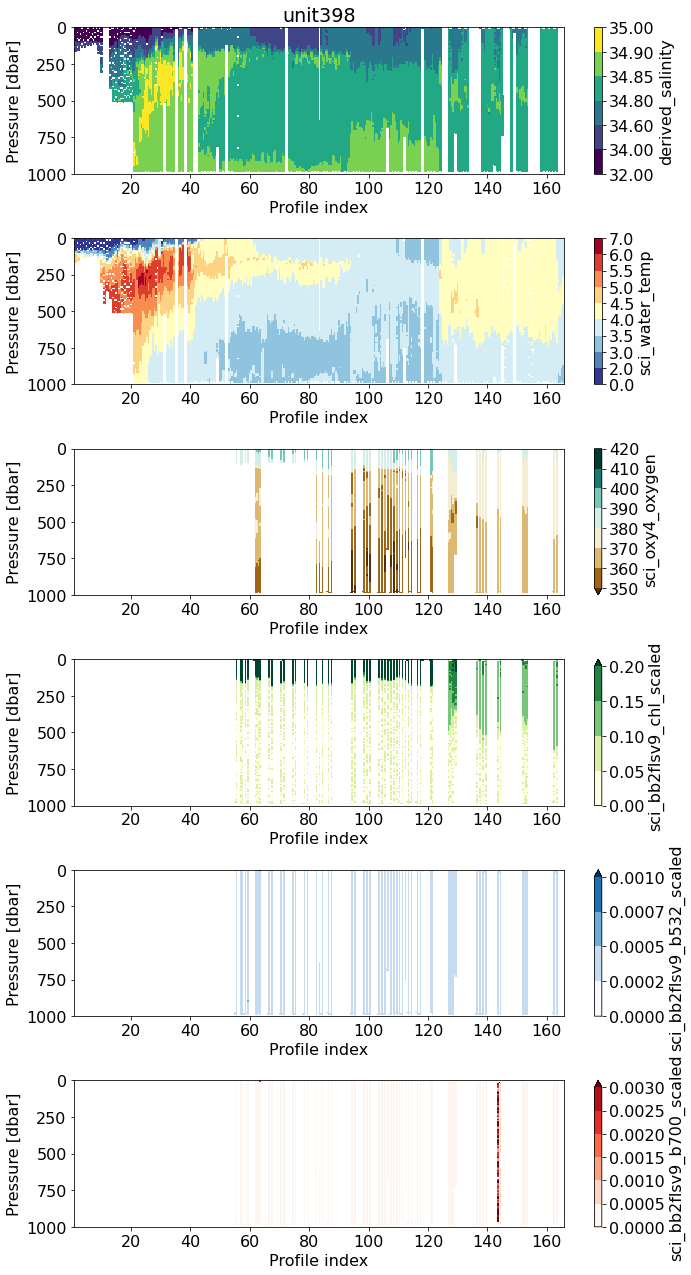

In [56]:
varlist = ['derived_salinity', 'sci_water_temp', 'sci_oxy4_oxygen',
           'sci_bb2flsv9_chl_scaled', 'sci_bb2flsv9_b532_scaled', 
           'sci_bb2flsv9_b700_scaled'
          ]

plot_sxn(grid398, varlist)